#### Random Forest

In [1]:
import pandas as pd
df = pd.read_csv("arrivals.csv")

In [2]:
df.head()

,Date,arrivals
0,1970-01,5158
1,1970-02,5436
2,1970-03,4814
3,1970-04,3284
4,1970-05,3754


In [3]:
df.tail()

,Date,arrivals
663,2025-04,174608
664,2025-05,132919
665,2025-06,138241
666,2025-07,200244
667,2025-08,198235


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      668 non-null    object
 1   arrivals  668 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.6+ KB


In [5]:
df.describe()

,arrivals
count,668.000000
mean,51230.163174
std,56117.724185
min,0.000000
25%,17658.750000
50%,31048.500000
75%,52449.250000
max,253169.000000


In [6]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

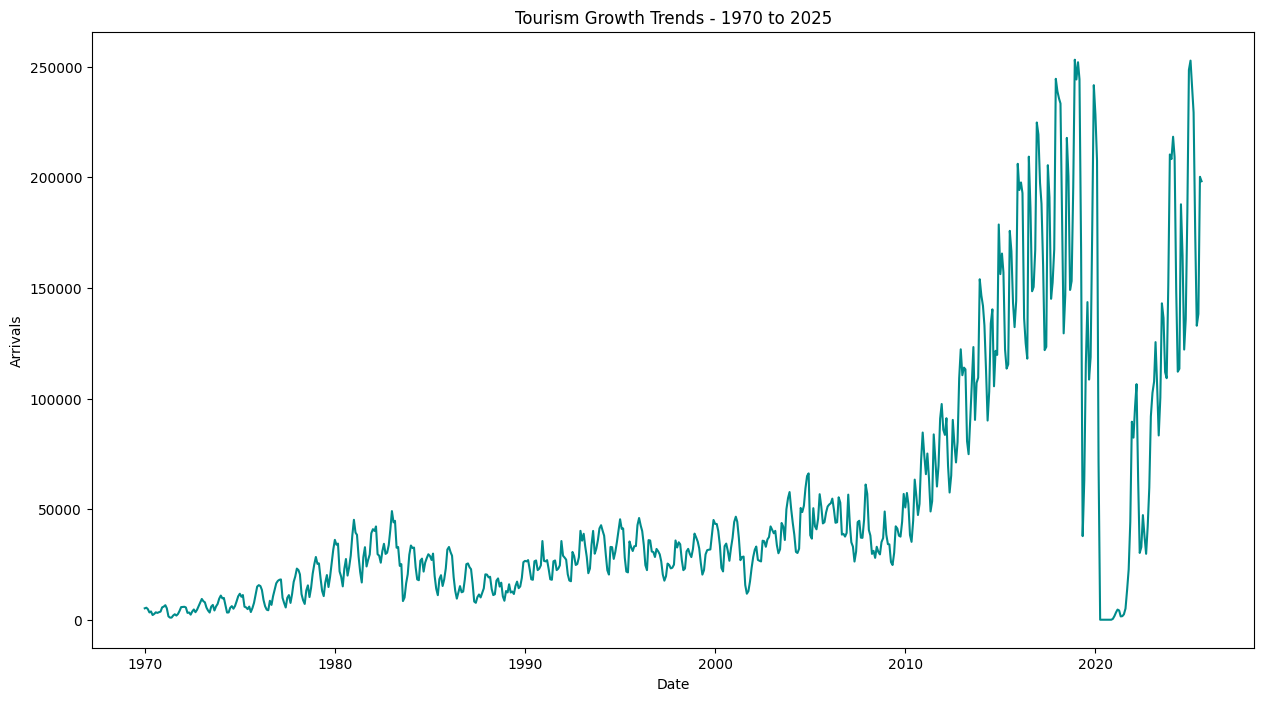

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df['Date'], df['arrivals'], color='#008B8B')
ax.set(xlabel="Date", ylabel="Arrivals", title=f"Tourist Arrivals - 1970 to 2025")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

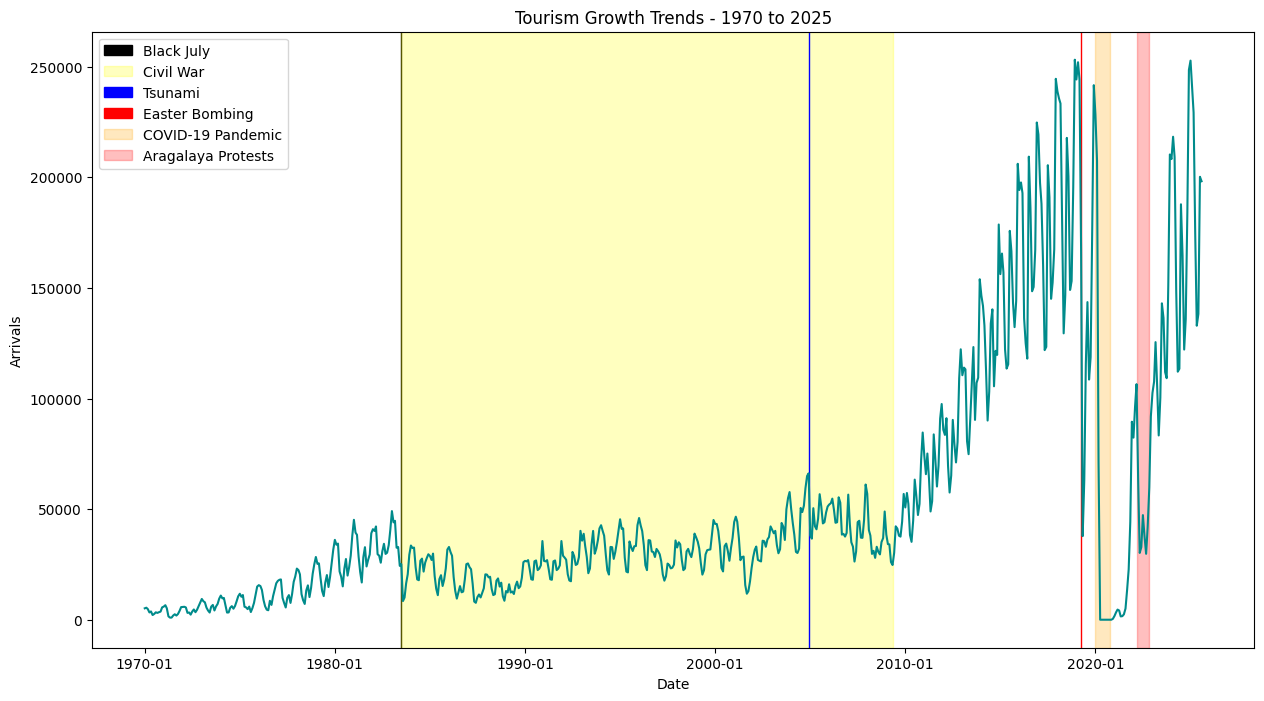

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df['Date'], df['arrivals'], color='#008B8B')

# Black July
ax.axvspan(pd.Timestamp('1983-07-01'), pd.Timestamp('1983-07-01'), color='black', alpha=1, label='Black July')

# Civil War
ax.axvspan(pd.Timestamp('1983-07-01'), pd.Timestamp('2009-05-01'), color='yellow', alpha=0.25, label='Civil War')

# Tsunami
ax.axvspan(pd.Timestamp('2004-12-01'), pd.Timestamp('2004-12-01'), color='blue', alpha=1, label='Tsunami')

# Easter Bombing
ax.axvspan(pd.Timestamp('2019-04-01'), pd.Timestamp('2019-04-01'), color='red', alpha=1, label='Easter Bombing')

# COVID-19 Pandemic
ax.axvspan(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-10-01'), color='orange', alpha=0.25, label='COVID-19 Pandemic')

# Aragalaya
ax.axvspan(pd.Timestamp('2022-03-01'), pd.Timestamp('2022-11-01'), color='red', alpha=0.25, label='Aragalaya Protests')

ax.set(xlabel="Date", ylabel="Arrivals", title="Tourist Arrivals - 1970 to 2025")
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
ax.legend()
plt.show()

In [9]:
df.set_index('Date', inplace=True)

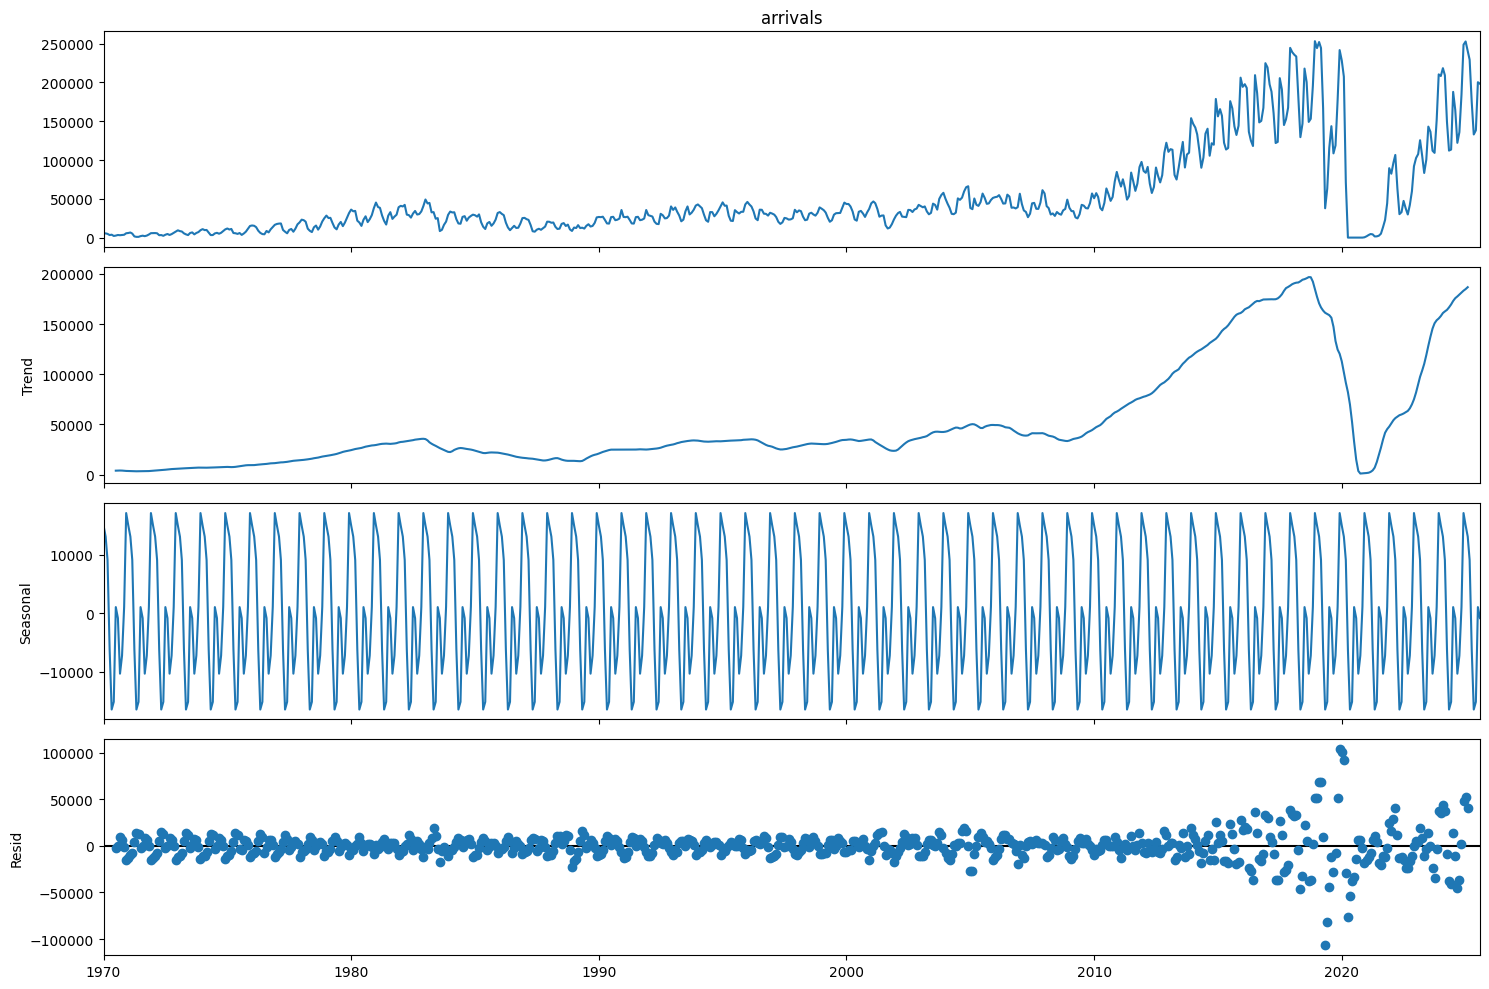

In [10]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['arrivals'], model='additive', period=12)

plt.rcParams["figure.figsize"] = (15, 10)

result.plot()
plt.tight_layout()
plt.show()

In [11]:
seasonal = result.seasonal

df['Month'] = df.index.month

seasonal_df = seasonal.to_frame(name='Seasonal')
seasonal_df['Month'] = df['Month']

seasonal_index = seasonal_df.groupby('Month')['Seasonal'].mean()

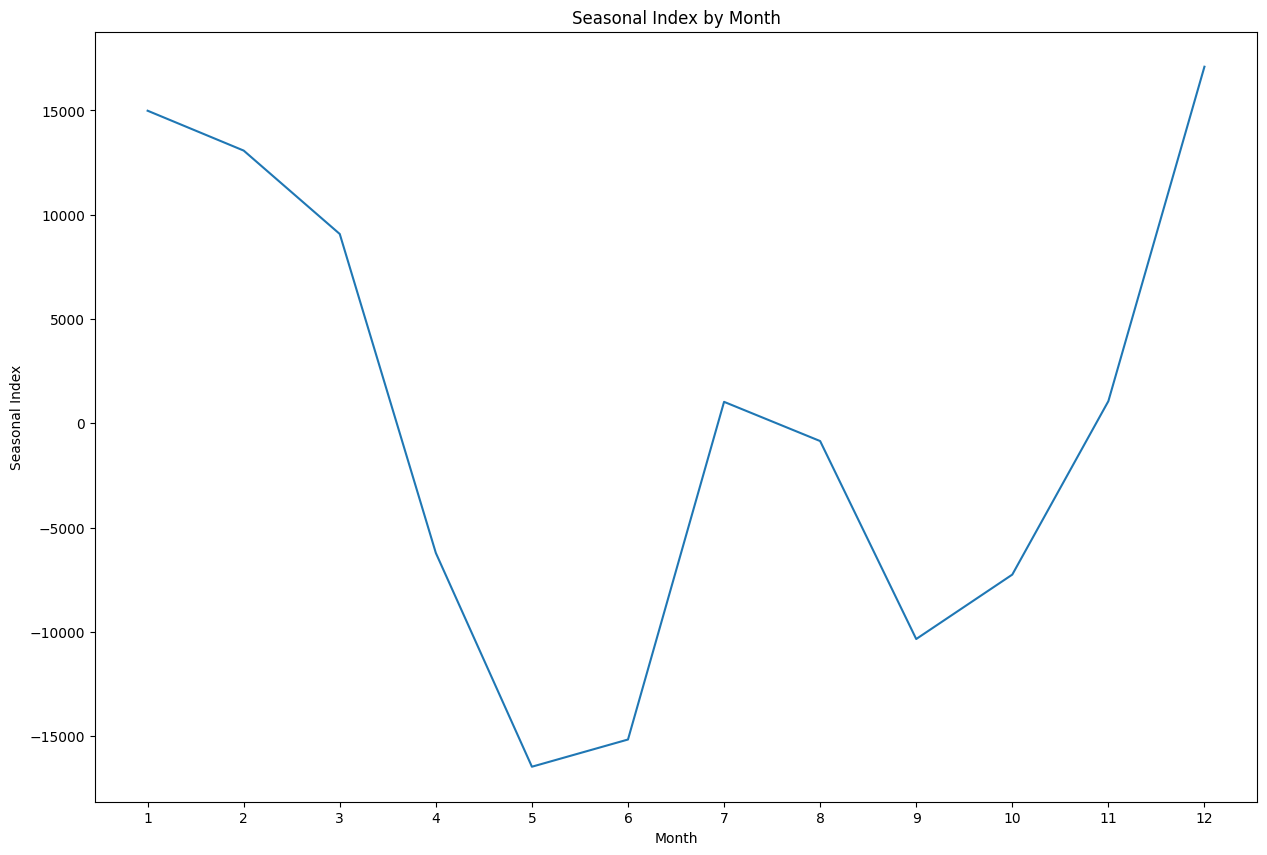

In [12]:
seasonal_index.plot(kind='line', title='Seasonal Index by Month')
plt.ylabel('Seasonal Index')
plt.xlabel('Month')
plt.xticks(range(1, 13))
plt.show()

#### Trend
Tourist arrivals generally show an upward trend. However, this trend was subdued during the civil war, the COVID-19 pandemic, and the Aragalaya protests.

#### Seasonality
Tourist arrivals are averagely highest in December and January month while it is lowest in May and June months.

In [13]:
df.reset_index(inplace=True)

The Random Forest model performs better on stationary data. To test the stationarity of the series, the Augmented Dickey–Fuller (ADF) test was conducted.

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['arrivals'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.878567744380577
p-value: 0.34220970737419387


Since the p-value is greater than 0.05, the series is non-stationary. Therefore, the series was detrended using first-order differencing.

In [15]:
df['diff'] = df['arrivals'].diff()
df.dropna(inplace=True)

result = adfuller(df['diff'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.86746065903963
p-value: 4.03337107137153e-05


Since the p-value is less than 0.05, the series is stationary, and we can proceed with modeling. Otherwise, it should also be deseasonalized as shown below.

In [16]:
#df['diff_1'] = df['arrivals'].diff()

#seasonal_period = 12
#df['diff_seasonal'] = df['diff_1'] - df['diff_1'].shift(seasonal_period)
#df.dropna(inplace=True)

#result = adfuller(df['diff_seasonal'])
#print(f'ADF Statistic: {result[0]}')
#print(f'p-value: {result[1]}')

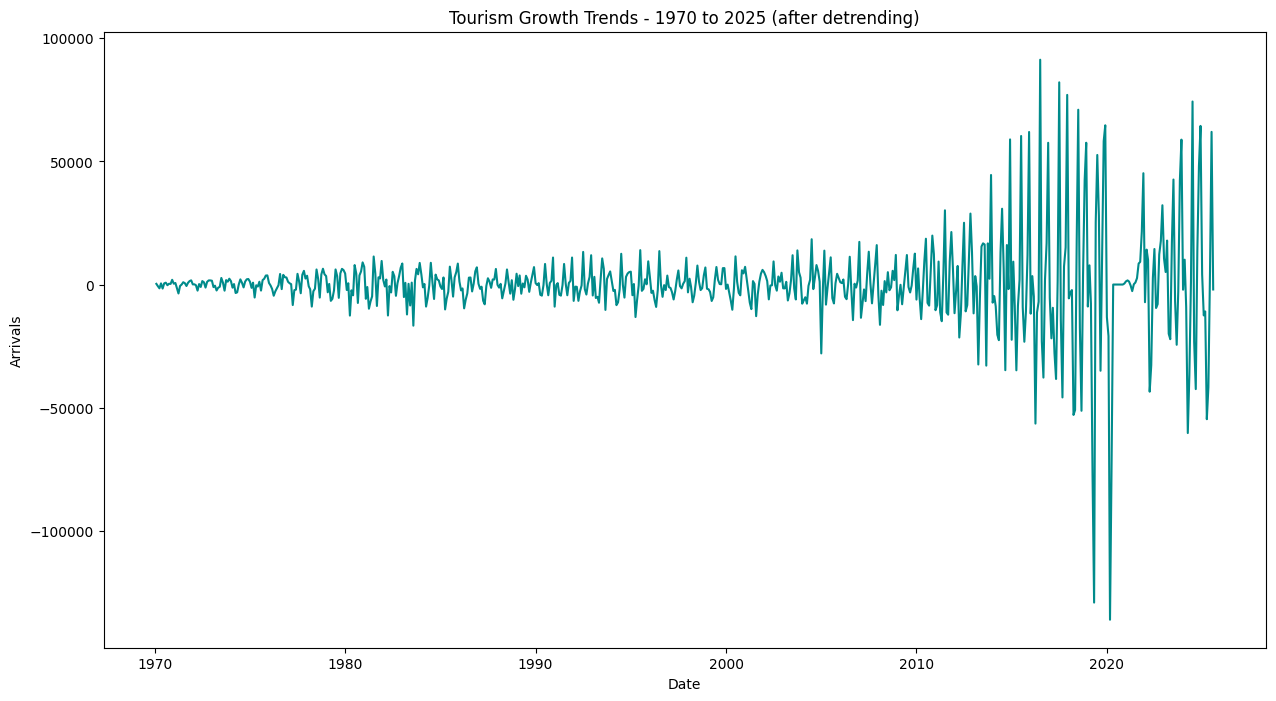

In [17]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df['Date'], df['diff'], color='#008B8B')
ax.set(xlabel="Date", ylabel="Arrivals", title=f"Tourism Growth Trends - 1970 to 2025 (after detrending)")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [18]:
df.set_index('Date', inplace=True)

In [19]:
# feature engineering
df['lag_1'] = df['diff'].shift(1)
df['rolling_mean_12'] = df['diff'].rolling(12).mean()
df = df.dropna()

In [20]:
features = ['lag_1', 'rolling_mean_12']
X = df[features]
y = df['diff']

In [21]:
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
pred_diff = model.predict(X_test)

In [24]:
last_train_value = df['arrivals'].iloc[train_size - 1]

pred_original = []
for d in pred_diff:
    last_train_value = last_train_value + d
    pred_original.append(last_train_value)

pred_original = np.clip(pred_original, 0, None)

MAE: 40342.42, MSE: 2909389903.25, RMSE: 53938.76


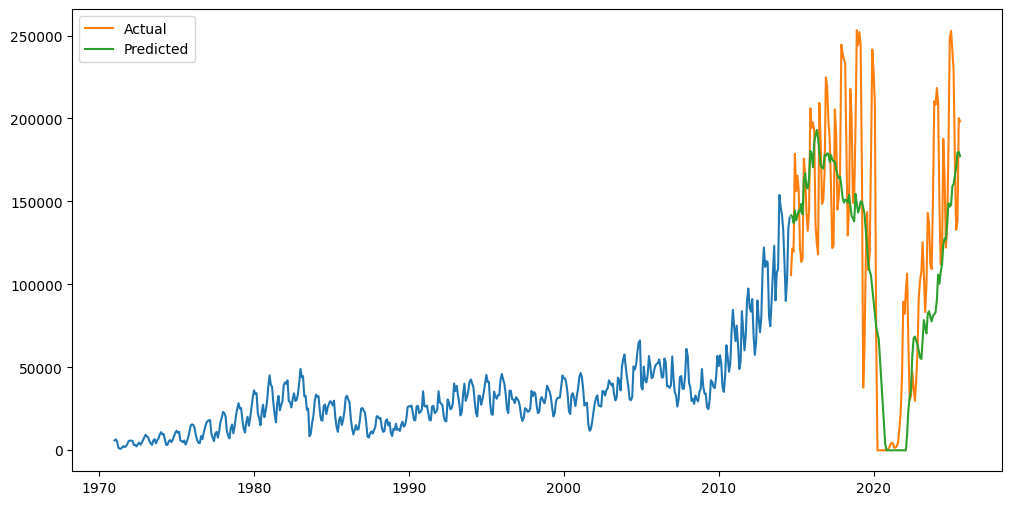

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_test_original = df['arrivals'].iloc[train_size:]

mae = mean_absolute_error(y_test_original, pred_original)
mse = mean_squared_error(y_test_original, pred_original)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df.index[:train_size], df['arrivals'].iloc[:train_size])
plt.plot(y_test_original.index, y_test_original, label='Actual')
plt.plot(y_test_original.index, pred_original, label='Predicted')
plt.legend()
plt.show()

#### LSTM

In [26]:
df = pd.read_csv("arrivals.csv")

In [27]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [28]:
# feature engineering
df['lag_1'] = df['arrivals'].shift(1)
df['rolling_mean_12'] = df['arrivals'].rolling(12).mean()
df = df.dropna()

In [29]:
features = ['lag_1', 'rolling_mean_12']
X = df[features]
y = df['arrivals']

In [30]:
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [31]:
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32)

In [ ]:
pred_lstm = model_lstm.predict(X_test_lstm)

In [ ]:
y_test_ori = df['arrivals'].iloc[train_size:]

mae = mean_absolute_error(y_test_ori, pred_lstm)
mse = mean_squared_error(y_test_ori, pred_lstm)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df.index[:train_size], df['arrivals'].iloc[:train_size])
plt.plot(y_test_original.index, y_test_original, label='Actual')
plt.plot(y_test_original.index, pred_original, label='Predicted')
plt.legend()
plt.show()

#### Prophet

In [ ]:
# !pip install prophet

In [ ]:
df = pd.read_csv("arrivals.csv")

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df_prophet = df[['Date', 'arrivals']].rename(columns={'Date':'ds', 'arrivals':'y'})

In [ ]:
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

In [ ]:
from prophet import Prophet

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model.fit(train_df)

In [ ]:
df_pred = model.make_future_dataframe(periods=len(test_df), freq='M')  # monthly frequency
forecast = model.predict(df_pred)

In [ ]:
y_true = test_df['y'].values
y_pred = forecast['yhat'].iloc[train_size:].values

df.set_index('Date', inplace=True)
test_df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(12,6))
plt.plot(df.index[:train_size], df['arrivals'].iloc[:train_size])
plt.plot(test_df.index, test_df['y'], label='')
plt.plot(forecast.index[train_size:], forecast['yhat'].iloc[train_size:], label='Predicted')
plt.legend()
plt.show()